In [74]:
import pandas as pd
import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
from urllib.request import urlopen
import re
from nltk.corpus import stopwords
import html2text
import gensim
import gensim.downloader as api
from gensim.models import word2vec

In [1]:
Dutch = 'https://www.gutenberg.org/cache/epub/39181/pg39181-images.html'
English = "https://www.gutenberg.org/cache/epub/1004/pg1004-images.html"
Finnish = "https://www.gutenberg.org/cache/epub/12546/pg12546.html"
German = "https://www.gutenberg.org/cache/epub/8085/pg8085.html"
Italian = "https://www.gutenberg.org/cache/epub/1000/pg1000-images.html"

languages = [Dutch, German, Italian, English, Finnish]
names = ['Dutch', 'German', 'Italian', 'English', 'Finnish']

In [45]:
Dutch = open('Dutch.txt').read()
English = open('English.txt').read()
Finnish = open('Finnish.txt').read()
German = open('German.txt').read()
Italian = open('Italian.txt').read()

In [90]:
def data_tokenizer(language, language_name, encoding = 'utf-8'):
    tokenized = nltk.word_tokenize(language)
    f=[word.lower() for word in tokenized if word.isalpha()]
    stop_words = set(nltk.corpus.stopwords.words('english')) | set(nltk.corpus.stopwords.words(language_name))
    [stopped] = [[i for i in j if i not in stop_words] for j in [f]]
    return stopped

In [91]:
tokenized_English = data_tokenizer(English,'English')
tokenized_German = data_tokenizer(German,'German')
tokenized_Italian = data_tokenizer(Italian,'Italian')
tokenized_Dutch = data_tokenizer(Dutch,'Dutch')
#tokenized_Spanish = data_tokenizer(Spanish,'Spanish')
tokenized_Finnish = data_tokenizer(Finnish,'Finnish')
tokenized_names = 'tokenized_'+pd.Series(names)
tokenized_languages = [tokenized_Dutch, tokenized_German, tokenized_Italian, tokenized_English, tokenized_Finnish]

In [95]:
def most_common_words(lang):
    df = pd.DataFrame(lang, columns = ['Language'])
    df_sorted = df.groupby(['Language'])['Language'].count().reset_index(
                        name='Count').sort_values(['Count'], ascending=False)
    return df_sorted.Language[:150].reset_index(drop=True)


In [96]:
eng150 = most_common_words(tokenized_English)
ger150 = most_common_words(tokenized_German)
ita150 = most_common_words(tokenized_Italian)
dut150 = most_common_words(tokenized_Dutch)
#spa150 = most_common_words(tokenized_Spanish)
fin150 = most_common_words(tokenized_Finnish)

token_df = pd.DataFrame([eng150, ger150, ita150, dut150, fin150], index = ["English","German","Italian","Dutch","Finnish"]).T

token_df

,English,German,Italian,Dutch,Finnish
0,thou,sprach,ch,den,mi
1,one,sah,sì,gij,mut
2,thee,drum,de,zoo,näin
3,unto,schon,quel,zóó,sa
4,upon,mehr,poi,wanneer,mun
...,...,...,...,...,...
145,ere,fand,color,nacht,eessä
146,whose,zurück,mezzo,gericht,näyttää
147,guide,läßt,indi,dichter,taivas
148,went,rede,sole,staan,beatrice


In [98]:
from simalign import SentenceAligner
aligner = SentenceAligner(model="bert", token_type="bpe", matching_methods="mai")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
2023-06-08 03:19:27,800 - simalign.simalign - INFO - Initialized the EmbeddingLoader with model: bert-base-multilingual-cased


In [99]:
def alingment(lang150):
    aligned = aligner.get_word_aligns(eng150.to_list(), lang150.to_list())
    mwmf = pd.DataFrame(aligned['mwmf'])
    return lang150.reindex(mwmf[1])

In [100]:
ger_aligned = alingment(ger150)
ita_aligned = alingment(ita150)
dut_aligned = alingment(dut150)
#spa_aligned = alingment(spa150)
fin_aligned = alingment(fin150)


In [102]:
aligned_df = pd.DataFrame([eng150, ger_aligned.reset_index(drop =True), ita_aligned.reset_index(drop =True), 
                           dut_aligned.reset_index(drop =True), fin_aligned.reset_index(drop =True)], index = ["English","German","Italian","Dutch","Finnish"]).T

In [103]:
aligned_df

,English,German,Italian,Dutch,Finnish
0,thou,wort,ch,den,mi
1,one,mehr,sì,gij,mut
2,thee,sieh,de,zoo,sa
3,unto,kreise,quel,eene,mut
4,upon,blick,ogne,zóó,mulle
...,...,...,...,...,...
161,NaN,zurück,può,NaN,eessä
162,NaN,tut,ove,NaN,käännyin
163,NaN,NaN,NaN,NaN,tietää
164,NaN,NaN,NaN,NaN,tuota


In [105]:
tokenized_English = eng150
tokenized_German = ger_aligned
tokenized_Italian = ita_aligned
tokenized_Dutch = dut_aligned
#tokenized_Spanish = spa_aligned
tokenized_Finnish = fin_aligned

In [106]:
def skipgram(language):
    return gensim.models.Word2Vec(language, vector_size = 50, sg = 1).wv
def cbow(language):
    return gensim.models.Word2Vec(language, vector_size = 50,sg = 0).wv

In [107]:
skipgram_English = skipgram(tokenized_English)
cbow_English = cbow(tokenized_English)
skipgram_Dutch = skipgram(tokenized_Dutch)
cbow_Dutch = cbow(tokenized_Dutch)
skipgram_German = skipgram(tokenized_German)
cbow_German = cbow(tokenized_German)
skipgram_Italian = skipgram(tokenized_Italian)
cbow_Italian = cbow(tokenized_Italian)
#skipgram_Spanish = skipgram(tokenized_Spanish)
#cbow_Spanish = cbow(tokenized_Spanish)
skipgram_Finnish = skipgram(tokenized_Finnish)
cbow_Finnish = cbow(tokenized_Finnish)
 

In [108]:
cbow = [cbow_Dutch, cbow_German, cbow_Italian, cbow_English, cbow_Finnish]
cbow_names = 'cbow_'+pd.Series(names)
skipgram = [skipgram_Dutch, skipgram_German, skipgram_Italian, skipgram_English, skipgram_Finnish]
skipgram_names = 'skipgram_'+pd.Series(names)

In [109]:
import matplotlib.pyplot as plt

def flat(model):
    vocab = list(model.index_to_key)
    vectors = model[vocab]
    vectors_flatten = vectors.flatten()
    return vectors_flatten

In [110]:
flat_skipgram_Dutch = flat(skipgram_Dutch)
flat_skipgram_German = flat(skipgram_German)
flat_skipgram_Italian = flat(skipgram_Italian)
flat_skipgram_English = flat(skipgram_English)
#flat_skipgram_Spanish = flat(skipgram_Spanish)
flat_skipgram_Finnish = flat(skipgram_Finnish)

flat_cbow_Dutch = flat(cbow_Dutch)
flat_cbow_German = flat(cbow_German)
flat_cbow_Italian = flat(cbow_Italian)
flat_cbow_English = flat(cbow_English)
#flat_cbow_Spanish = flat(cbow_Spanish)
flat_cbow_Finnish = flat(cbow_Finnish)


In [111]:
var_holder = {}
for i in cbow:
    langname = names[cbow.index(i)]
    var_holder['flat_cbow_' + langname]= flat(i)

locals().update(var_holder)
flat_cbow_names = 'flat_cbow_'+pd.Series(names)

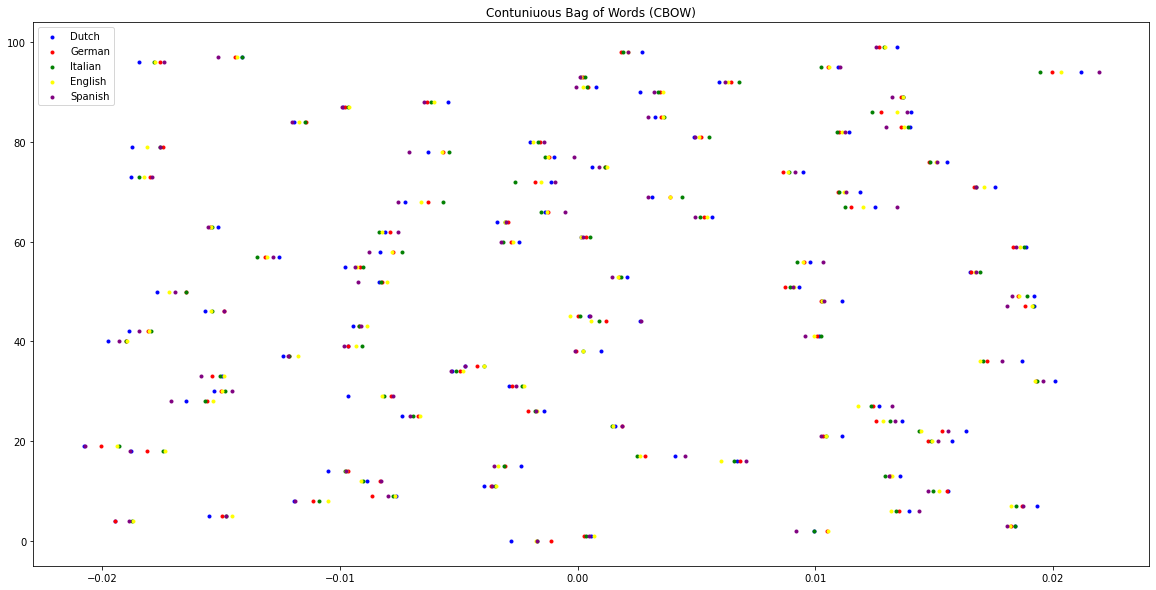

In [112]:
def plot(model, color = 'blue'):
    plt.scatter(model[:100], np.arange(0,100), marker=".",c= color)
plt.figure(figsize=(20,10))
plt.title('Contuniuous Bag of Words (CBOW)')
#plotting functions against their indexes
plot(flat_cbow_Dutch, color = 'blue')
plot(flat_cbow_German, color = 'red')
plot(flat_cbow_Italian, color = 'green')
plot(flat_cbow_English, color = 'yellow')
#plot(flat_cbow_Spanish, color = 'black')
plot(flat_cbow_Finnish, color = 'purple')

plt.legend(names)
plt.show()

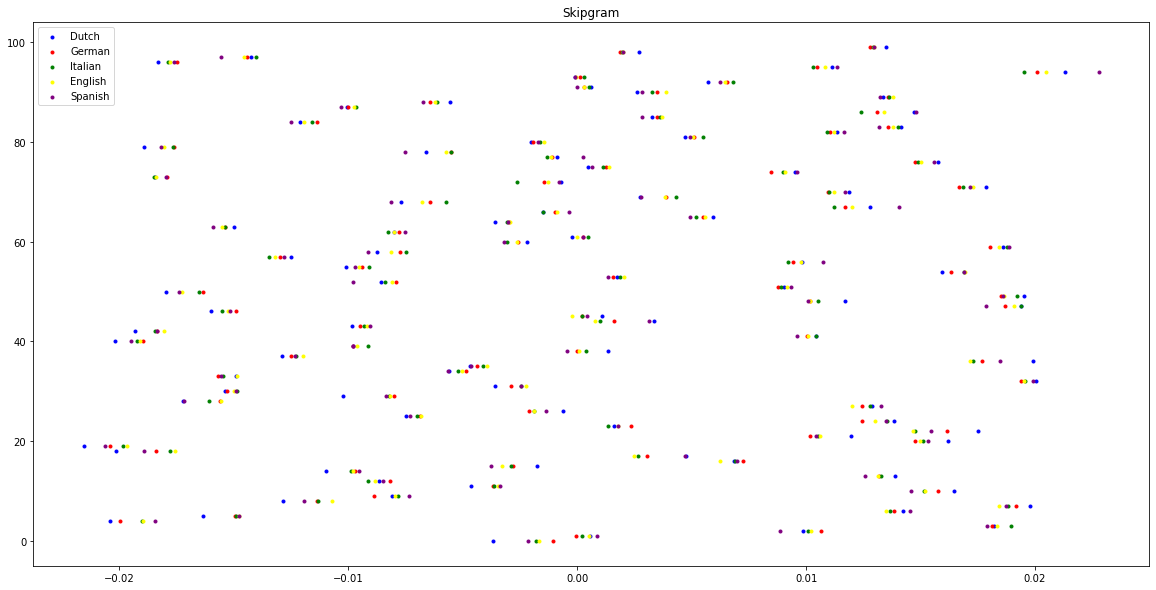

In [113]:
plt.figure(figsize=(20,10))
plt.title('Skipgram')
plot(flat_skipgram_Dutch, color = 'blue')
plot(flat_skipgram_German, color = 'red')
plot(flat_skipgram_Italian, color = 'green')
plot(flat_skipgram_English, color = 'yellow')
#plot(flat_skipgram_Spanish, color = 'black')
plot(flat_skipgram_Finnish, color = 'purple')
plt.legend(names)
plt.show()

In [120]:
from sklearn.metrics.pairwise import cosine_similarity
for_sim = pd.DataFrame([flat_skipgram_Dutch, flat_skipgram_German, flat_skipgram_Italian, flat_skipgram_English, flat_skipgram_Finnish][:100])
for_sim.index = ["Dutch","German","Italian","English","Finnish"]
for_sim.dropna(axis = 1,inplace=True)

In [121]:
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(for_sim)
pd.DataFrame(sim)

,0,1,2,3,4
0,0.999999,0.998921,0.998574,0.999007,0.998917
1,0.998921,1.000000,0.999316,0.999607,0.999064
2,0.998574,0.999316,1.000000,0.999758,0.998925
3,0.999007,0.999607,0.999758,1.000000,0.999285
4,0.998917,0.999064,0.998925,0.999285,1.000000


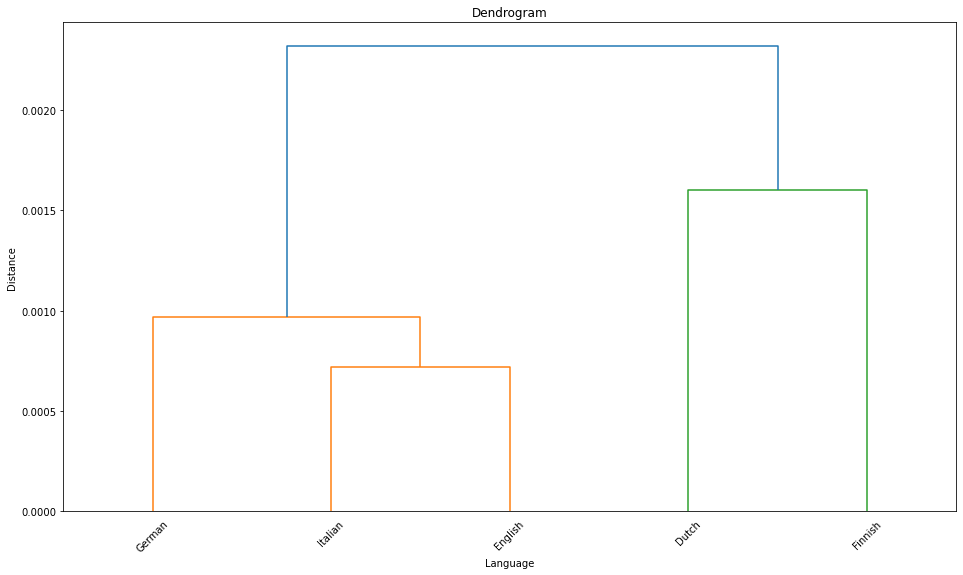

In [124]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(sim, 'ward')
plt.figure(figsize=(16, 9))
labels = for_sim.columns
dendrogram(Z, leaf_rotation=90, leaf_font_size=7., labels = for_sim.index)
plt.title('Dendrogram')
plt.ylabel('Distance')
plt.xlabel('Language')
plt.xticks(rotation = 45, fontsize = 10)

plt.show()

In [127]:
for_sim_cbow = pd.DataFrame([flat_cbow_Dutch, flat_cbow_German, flat_cbow_Italian, flat_cbow_English, flat_cbow_Finnish][:100])
for_sim_cbow.index = ["Dutch","German","Italian","English","Finnish"]
for_sim_cbow.dropna(axis = 1, inplace = True)


In [128]:
sim_cbow = cosine_similarity(for_sim_cbow)
pd.DataFrame(sim_cbow)


,0,1,2,3,4
0,1.000000,0.999428,0.999250,0.999526,0.999386
1,0.999428,1.000001,0.999611,0.999744,0.999494
2,0.999250,0.999611,1.000000,0.999838,0.999214
3,0.999526,0.999744,0.999838,1.000000,0.999436
4,0.999386,0.999494,0.999214,0.999436,1.000000


(array([ 5, 15, 25, 35, 45]),
 [Text(5, 0, 'Italian'),
  Text(15, 0, 'German'),
  Text(25, 0, 'English'),
  Text(35, 0, 'Dutch'),
  Text(45, 0, 'Finnish')])

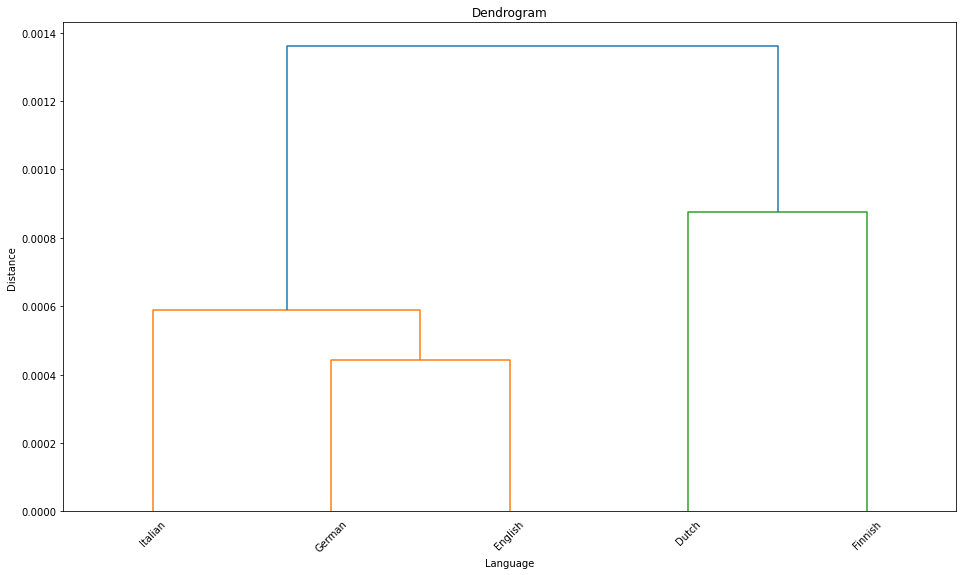

In [129]:
Z_cbow = linkage(sim_cbow, 'ward')
plt.figure(figsize=(16, 9))
labels = for_sim_cbow.columns
dendrogram(Z_cbow, leaf_rotation=90, leaf_font_size=7., labels = for_sim_cbow.index)
plt.title('Dendrogram')
plt.ylabel('Distance')
plt.xlabel('Language')
plt.xticks(rotation = 45, fontsize = 10)
